# Ambiguous map patterns from stratigraphy

### This notebook is a preliminary exploration into ambiguous map patterns from stratigraphy. 

In [1]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import verde as vd

In [2]:
%matplotlib inline

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## First define some global variables

In [3]:
# this creates dummy NAMES for the formations
NAMES = [
    "one",
    "two",
]  
# this is the number of tops you want in your training data
NUMBER_OF_LAYERS = 2  
# minimum value for top depths
SMALLEST = -6
# maximum value for top depths
LARGEST = 12
# number of steps between top depths
STEP = 2


### Next some functions that build our earth models

In [4]:
len(np.random.random_integers(0,40,400))

<ipython-input-4-b67918cdcf3a>:1: DeprecationWarning: This function is deprecated. Please call randint(0, 40 + 1) instead
  len(np.random.random_integers(0,40,400))


400

In [5]:
def rotation(dataframe, j):
    """
    Creates spatial samples and rotates them in the xy plane
    param dataframe: dataframe output from stratigraphy generation
    param j: controls the rotation of the dataset 0 is no rotation
    """
    x = np.arange(0, 40, 0.1)
    y = np.random.randint(0, 10, len(x))
    # this is the rotation of the generated data
    if j % 0.2 > 0.1:
        dataframe["ex"] = x * np.cos(-j / 2) - y * np.sin(-j / 2)
        dataframe["ey"] = y * np.cos(-j / 2) - x * np.sin(-j / 2)
    else:
        dataframe["ex"] = x * np.cos(j / 2) - y * np.sin(j / 2)
        dataframe["ey"] = y * np.cos(j / 2) - x * np.sin(j / 2)
    return dataframe


def depth_to_thickness(neighborhood, dataframe):
    """
    Converts the depth dataframe from the adjacent wells function to thicknesses
    param neighborhood: dataframe output from `adjacent_wells`
    param dataframe: dataframe output from function `missing`
    """
    locations = pd.DataFrame()
    df = pd.DataFrame()
    thicknesses = neighborhood.diff(axis=1)
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns="zero", inplace=True)
    locations = pd.concat((locations, dataframe.iloc[:, -2:]))
    df = pd.concat((df, thicknesses))
    return df, locations
  
    
def truncation(smallest, largest, step, names, number_of_layers, j):
    """
    Creates truncated stratal geometries using a min, max, step, names and numbers of layers
    param smallest: the smallest integer value for stratigraphy
    param largest: the largest integer value for stratigraphy
    param step: the size of the step from smallest to largest
    param names: names of the layers as strings in a list
    param number_of_layers: number of layers to evaluate
    param j: float value that controls the wavelength of the sine curve
    """
    rolling = pd.DataFrame()
    j = np.round(j, decimals=3) + 0.5
    elevation_random = sorted(
        np.random.uniform(smallest, largest, number_of_layers - 1)
    )
    for i in range(len(names[0 : number_of_layers - 1])):

        basement = (
            0.001
            + (10) * np.sin(1 - np.arange(0, 40, 0.1) / (j * 2) + 0.001)
            + np.random.rand(400) / 5
        )
        elevation = (
            np.full(
                400,
                basement.max()
                + np.random.uniform(basement.min() / 2, basement.max() / 64, 1),
            )
            + np.random.rand(400) / 5
        )
        topbasement = np.where(basement > elevation, elevation, basement)

        rolling["zero"] = topbasement
        layer_elevation = (
            0.001
            + (10) * np.sin(1 - np.arange(0, 40, 0.1) / (j * 2) + 0.001)
            + abs(elevation_random[i])
            + np.random.rand(400) / 5
        )
        layer_elevation = np.where(
            layer_elevation < basement, basement, layer_elevation
        )
        layer_elevation = np.where(
            layer_elevation > elevation, elevation, layer_elevation
        )
        rolling[names[i]] = layer_elevation
    return rolling

def onlap(smallest, largest, step, names, number_of_layers, j):
    """
    Creates onlap stratal geometries using a min, max, step, names and numbers of layers
    param smallest: the smallest integer value for stratigraphy
    param largest: the largest integer value for stratigraphy
    param step: the size of the step from smallest to largest
    param names: names of the layers as strings in a list
    param number_of_layers: number of layers to evaluate
    param j: float value that controls the wavelength of the sine curve
    """
    rolling = pd.DataFrame()
    j = np.round(j, decimals=3) + 0.5
    elevation_random = sorted(
        np.random.uniform(smallest, largest, number_of_layers - 1)
    )
    for i in range(len(names[0 : number_of_layers - 1])):
        basement = (
            0.001
            + (10) * np.sin(1 - np.arange(0, 40, 0.1) / (j * 2) + 0.001)
            + np.random.rand(400) / 5
        )
        elevation = (
            np.full(
                400,
                basement.max()
                + np.random.uniform(basement.min() / 2, basement.max() / 64, 1),
            )
            + np.random.rand(400) / 5
        )
        topbasement = np.where(basement > elevation, elevation, basement)
        rolling["zero"] = topbasement
        strat_elevation = (
            np.full(400, elevation_random[i]) + np.random.rand(400) / 5
        )
        onlap = np.where(strat_elevation > basement, strat_elevation, basement)
        layer_elevation = np.where(onlap > elevation, elevation, onlap)
        rolling[names[i]] = layer_elevation
    return rolling

def horizontal(smallest, largest, step, names, number_of_layers):
    """
    Creates onlap stratal geometries using a min, max, step, names and numbers of layers
    param smallest: the smallest integer value for stratigraphy
    param largest: the largest integer value for stratigraphy
    param step: the size of the step from smallest to largest
    param names: names of the layers as strings in a list
    param number_of_layers: number of layers to evaluate
 
    """
    rolling = pd.DataFrame()
    elevation_random = sorted(
        np.random.uniform(smallest, largest, number_of_layers - 1)
    )
    for i in range(len(names[0 : number_of_layers - 1])):
        strat_elevation = (
            np.full(400, elevation_random[i]) + np.random.rand(400) / 5
        )
        basement = strat_elevation - abs(
            np.random.uniform(smallest, largest)
            + np.random.rand(400) / 5
        )
        elevation = (
            np.full(400, strat_elevation + elevation_random[i])
            + np.random.rand(400) / 5
        )
        topbasement = np.where(basement > elevation, elevation, basement)
        layer_elevation = np.where(
            strat_elevation > elevation, elevation, strat_elevation
        )
        rolling["zero"] = topbasement
        rolling[names[i]] = layer_elevation
    return rolling


### Now let's use the functions to create formation top depths, place them in an 2d x-y plane, and calculate thickness for each point

In [6]:
np.random.seed(18)
truncated = truncation(SMALLEST, LARGEST, STEP, NAMES, NUMBER_OF_LAYERS, 10)
trunc_rotated = rotation(truncated, 0)
trunc_thickness, trunc_locations = depth_to_thickness(trunc_rotated, trunc_rotated)

In [7]:
np.random.seed(18)
onlapping = onlap(SMALLEST, LARGEST, STEP, NAMES, NUMBER_OF_LAYERS, 10)
onlap_rotated = rotation(onlapping, 0)
onlap_thickness, onlap_locations = depth_to_thickness(onlap_rotated, onlap_rotated)

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
np.random.seed(18)
horizontally = horizontal(SMALLEST, LARGEST, STEP, NAMES, NUMBER_OF_LAYERS)
horiz_rotated = rotation(horizontally, 0)
horiz_thickness, horiz_locations = depth_to_thickness(horiz_rotated, horiz_rotated)

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## now let's grid the data using Verde and plot it up

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Angular Unconformity Thickness')

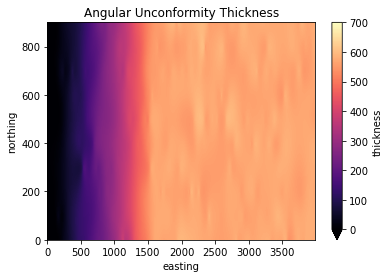

In [9]:
spline = vd.Spline()
spline.fit((trunc_locations.ex*100, trunc_locations.ey*100), trunc_thickness.one*100)
AUIGRID = spline.grid(spacing=1, data_names=["thickness"])
AUIGRID.thickness.plot.pcolormesh(cmap="magma", vmin=0, vmax=700)
plt.title("Angular Unconformity Thickness")

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Angular Unconformity Structure')

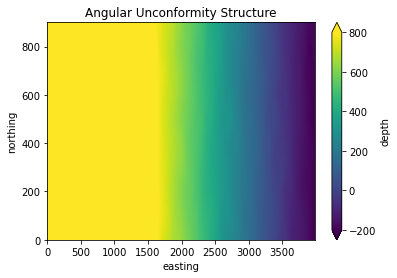

In [10]:
spline = vd.Spline()
spline.fit((trunc_locations.ex*100, trunc_locations.ey*100), trunc_rotated.one*100)
AUSGRID = spline.grid(spacing=1, data_names=["depth"])
AUSGRID.depth.plot.pcolormesh(cmap="viridis", vmin=-200, vmax=800)
plt.title("Angular Unconformity Structure")

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Onlap Thickness')

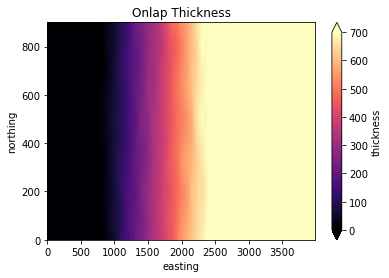

In [11]:
spline = vd.Spline()
spline.fit((onlap_locations.ex*100, onlap_locations.ey*100), onlap_thickness.one*100)
OLIGRID = spline.grid(spacing=1, data_names=["thickness"])
OLIGRID.thickness.plot.pcolormesh(cmap="magma", vmin=0, vmax=700)
plt.title("Onlap Thickness")

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Angular Unconformity Structure')

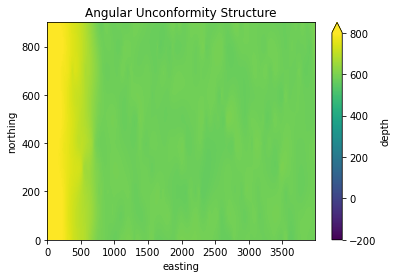

In [12]:
spline = vd.Spline()
spline.fit((onlap_locations.ex*100, onlap_locations.ey*100), onlap_rotated.one*100)
OLSGRID = spline.grid(spacing=1, data_names=["depth"])
OLSGRID.depth.plot.pcolormesh(cmap="viridis", vmin=-200, vmax=800)
plt.title("Angular Unconformity Structure")

## Lastly let's make the plot look like it does in the paper in Figure 2

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


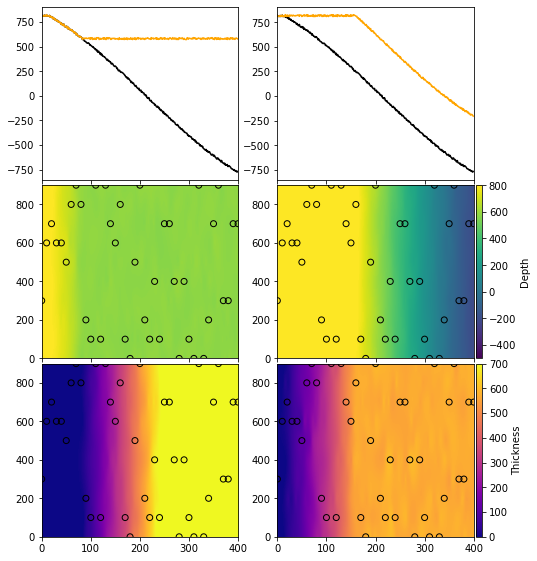

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(20, 25))
fig.set_size_inches(7.5, 9.75)
fig.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.03
)

axes[0, 0].plot(onlapping.zero * 100, c="black")
axes[0, 0].plot(onlapping.one * 100, c="orange")

#axes[0, 0].plot(S2[2] * 100, c="orange")

axes[0, 1].plot(truncated.zero * 100, c="black")
axes[0, 1].plot(truncated.one * 100, c="orange")
#axes[0, 1].plot(S3[1] * 100, c="orange")

im0 = axes[1, 0].imshow(
    OLSGRID.depth,
    extent=[0, 400, 0, 900],
    aspect="auto",
    cmap="viridis",
    vmin=-500,
    vmax=800,
)
axes[1, 0].scatter(onlapping.ex * 100, onlapping.ey*100, edgecolor='k', c='none')

im1 = axes[1, 1].imshow(
    AUSGRID.depth,
    extent=[0, 400, 0, 900],
    aspect="auto",
    cmap="viridis",
    vmin=-500,
    vmax=800,
)
axes[1, 1].scatter(truncated.ex * 100, truncated.ey*100, edgecolor='k', c='none')


im2 = axes[2, 0].imshow(
    OLIGRID.thickness,
    extent=[0, 400, 0, 900],
    aspect="auto",
    cmap="plasma",
    vmin=0,
    vmax=700,
)
axes[2, 0].scatter(onlapping.ex * 100, onlapping.ey*100, edgecolor='k', c='none')

axes[2, 1].scatter(truncated.ex * 100, truncated.ey*100, edgecolor='k', c='none')

im3 = axes[2, 1].imshow(
    AUIGRID.thickness,
    extent=[0, 400, 0, 900],
    aspect="auto",
    cmap="plasma",
    vmin=0,
    vmax=700,
)


fig.subplots_adjust(left=0.07, right=0.87)
# Add the colorbar outside...
box = axes[1, 1].get_position()
pad, width = 0.005, 0.01
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(im0, cax=cax, label="Depth")

box = axes[2, 1].get_position()
pad, width = 0.005, 0.01
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(im3, cax=cax, label="Thickness")

# fig.savefig('figure2.pDF')

In [14]:
truncated.ex

0       0.0
1       0.1
2       0.2
3       0.3
4       0.4
       ... 
395    39.5
396    39.6
397    39.7
398    39.8
399    39.9
Name: ex, Length: 400, dtype: float64